0
Actual DoAs: [16]
MUSIC DoAs: [16 74]
1
Actual DoAs: [149]
MUSIC DoAs: [ 31 149]
2
Actual DoAs: [131]
MUSIC DoAs: [ 49 131]
3
Actual DoAs: [42]
MUSIC DoAs: [ 42 138]
4
Actual DoAs: [162]
MUSIC DoAs: [ 18 108 162]
5
Actual DoAs: [108]
MUSIC DoAs: [ 72 108 162]
6
Actual DoAs: [42]
MUSIC DoAs: [ 42 138]
7
Actual DoAs: [148]
MUSIC DoAs: [ 32 122 148]
8
Actual DoAs: [115]
MUSIC DoAs: [ 65 115 155]
9
Actual DoAs: [82]
MUSIC DoAs: [ 8 82]


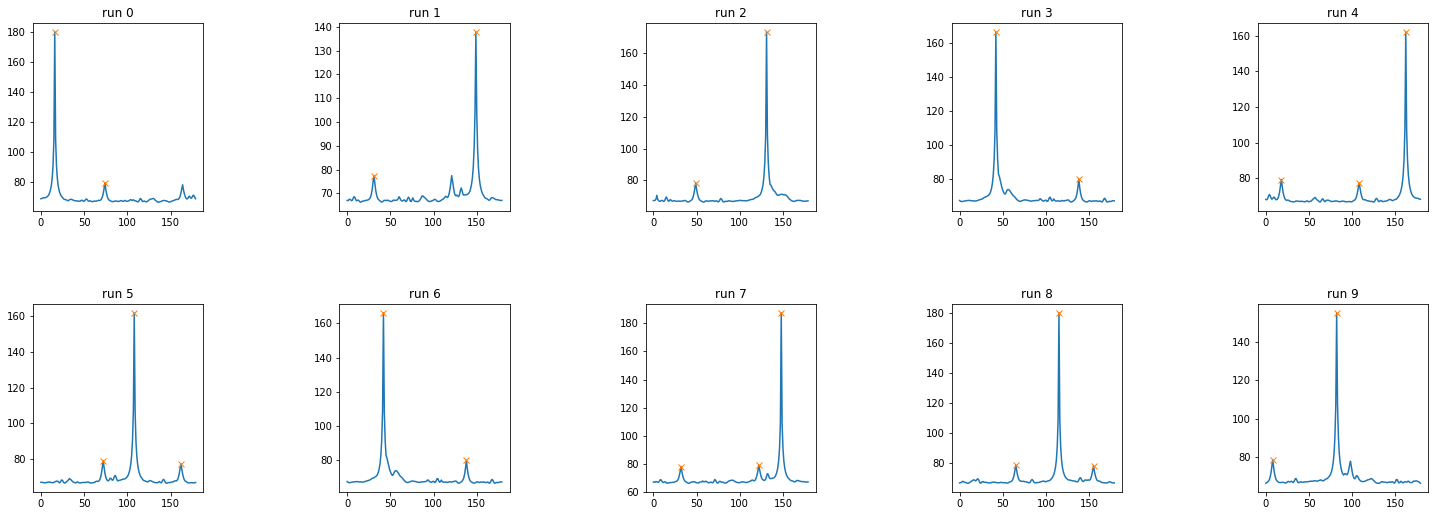

In [50]:
#Implementation found in https://github.com/dengjunquan/DoA-Estimation-MUSIC-ESPRIT/blob/master/DoAEstimation.py
# https://dengjunquan.github.io/posts/2018/08/DoAEstimation_Python/

import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as LA
import scipy.signal as ss
import operator
import math
import os
import datetime
import logging



#### LITTLE BUG if one of the thetas is in the extremes (0 or 179) the graph is good but not retrieved

# Functions
'''
'''
def music(CovMat,L,N,array,Angles, frequency):
    # CovMat is the signal covariance matrix, L is the number of sources, N is the number of antennas
    # array holds the positions of antenna elements 
    #(array and Angles ONLY USEFUL FOR response vector so should give response vector instead)
    # Angles are the grid of directions in the azimuth angular domain
    _,V = LA.eig(CovMat)
    #print(V)
    #print("JUSTE EN HAUT")
    Qn  = V[:,L:N]
    numAngles = Angles.size
    pspectrum = np.zeros(numAngles)
    for i in range(numAngles):
        av = array[:,Angles[i],frequency]
        pspectrum[i] = 1/LA.norm((Qn.conj().transpose()@av))
    
    psindB    = np.log10(10*pspectrum/pspectrum.min())
    #DoAsMUSIC,_= ss.find_peaks(psindB, height=3)
    return psindB


outpath = os.path.join('output',  '{:%Y%m%d_%H%M}'.format(datetime.datetime.now()))
if not os.path.exists(outpath):
    os.makedirs(outpath)

logfile = os.path.join(outpath, "log.txt")

logging.basicConfig(filename=logfile, format='%(asctime)s %(message)s', level=logging.INFO)
logger = logging.getLogger(__name__)


lamda = 1 # wavelength
kappa = np.pi/lamda # wave number
L = 1  # number of sources
snr = 20 # signal to noise ratio
n_samples = 128


#H_theta_time_total = np.load('lego1_h_theta_time.npy')    

dev = 'Omnidirectional' # Change if using Kemar or lego
logger.info('Load transfer functions %s'%dev)

runs = 10

logger.info('Number of runs %s'%(runs))
logger.info('Noise in decibel %s'%(snr))
logger.info('Number of sources %s'%(L))


'''
Generation H_theta omnidirectional (instead of load)
'''

# Decided by me. Should it be random ? or special ones ? 
# If we want less mics put less positions
mic_positions = np.array([(1,0), (0,1), (0,0), (-1,0), (0,-1)])

number_mics = mic_positions.shape[0]
N = number_mics


# We want a discretization of every 2 degrees
step = 2
number_angles = int(360/step)
# the different frequencies
c = 340.29 #speed of sound 340.29 m/s
sample_rate = 8000 # The maximum frequency we want to use
freq = np.fft.rfftfreq(n_samples, d=1./(2*sample_rate))
number_frequencies = int(n_samples/2 + 1)


H_theta_freq_total = np.zeros((number_mics, number_angles, number_frequencies), dtype=complex)


for index_H in range(number_angles):
    thetaAngle = step*index_H
    # We calculate the distances between the source and the different microphones
    # This is an hypothetic distance, as the micrphone is considered "far away", using the direction of the signal

    horizontalDistance = mic_positions[:,0] - math.cos(math.radians(thetaAngle))
    verticalDistance = mic_positions[:,1] - math.sin(math.radians(thetaAngle))
    distanceSourceMicrophones = np.sqrt(np.power(horizontalDistance, 2) + np.power(verticalDistance, 2))

    tau = distanceSourceMicrophones/c

    tau_reshaped = np.transpose(np.array([tau,]*freq.shape[0]))
    freq_reshaped = np.array([freq,]*tau.shape[0])
    
    H_theta_freq_total[:,index_H,:] = np.exp(-freq_reshaped*1j*tau_reshaped)

    
numFrequencies = H_theta_freq_total.shape[2]

'''
End Generation H_theta omnidirectional
'''


logger.info('Number of frequencies %s'%(numFrequencies))    

#Example Getting the first frquency of the 12th angle
#H_theta_freq_test = H_theta_freq_total[:,12,1]
    
Df = H_theta_freq_total.shape[1] #number of directions for a fine discretization
xPlot = 10 #runs/yplot
yPlot = 5 #runs/xplot
fig = plt.figure(figsize=(25,50))#give enough size to plot 50 subplots

for rns in range(runs):
    print(rns)

    # random source directions in degrees (actually it's the indexes for degrees times 2)
    Thetas = np.random.choice(range(Df), L, replace=False) 

    #Thetas[2] = 0 If i want to try extremes ones to debug

    Alphas = np.random.randn(L) + np.random.randn(L)*1j # random source powers

    Alphas = np.sqrt(1/2)*Alphas

    Angles = np.arange(Df, dtype=np.int64)*360./Df # list of angles in degrees
    Angles = (Angles/2).astype(int)

    numAngles = Angles.size

    psindTotal = np.zeros((Df, ))

    #not taking the first frequency because neutral one
    for frequency in range (1, numFrequencies): 

        numrealization = 100
        H = np.zeros((N,numrealization)) + 1j*np.zeros((N,numrealization))
        for iter in range(numrealization):
            htmp = np.zeros(N)
            #Signal generation
            for i in range(L):
                pha = np.exp(1j*2*np.pi*np.random.rand(1))
                htmp = htmp + pha*Alphas[i]*H_theta_freq_total[:,Thetas[i],frequency]
            #Adding noise
            H[:,iter] = htmp + np.sqrt(0.5/snr)*(np.random.randn(N)+np.random.randn(N)*1j)
        CovMat = H@H.conj().transpose()

        # MUSIC algorithm
        psindB = music(CovMat,L,N,H_theta_freq_total,Angles, frequency)

        psindTotal = psindTotal + psindB

    #TO change the height when we change n_samples
    #TO DO : use prominence and take numberOfSources highest
    DoAsMUSIC,_= ss.find_peaks(psindTotal, prominence= 10)

    plt.subplot(xPlot, yPlot, rns+1)
    plt.plot(Angles,psindTotal)
    plt.plot(Angles[DoAsMUSIC],psindTotal[DoAsMUSIC],'x')
    plt.title('run %s'%(rns))

    print('Actual DoAs: %s'%(np.sort(Thetas)))
    print('MUSIC DoAs: %s'%(np.sort(Angles[DoAsMUSIC])))
    
    logger.info('Actual DoAs: %s'%(np.sort(Thetas)))
    logger.info('MUSIC DoAs: %s'%(np.sort(Angles[DoAsMUSIC])))

    musicContainedThetas = np.isin(DoAsMUSIC, Thetas)

    thetasContainedMusic = np.isin(Thetas, DoAsMUSIC)

    fullyContained = np.all(np.append(musicContainedThetas, thetasContainedMusic))
    logger.info('Run %s : '%(rns))

    if fullyContained:
        logger.info('Found every source')
    else:
        numberWrongSource = np.count_nonzero(musicContainedThetas==False)
        numberNotFoundSource = np.count_nonzero(thetasContainedMusic==False)
        if(numberNotFoundSource == 0):
            logger.info('Found every source but found %s more sources'%(numberWrongSource))
        elif(numberWrongSource == 0):
            logger.info('Found only good sources but didn\'t find %s source(s)' %(numberNotFoundSource))
        else:
            logger.info('Found %s wrong source(s) and didn\'t find %s source(s)' %(numberWrongSource, numberNotFoundSource))
        

    
    #print('Actual DoAs:',np.sort(Thetas),'\n')
    #print('MUSIC DoAs:',np.sort(Angles[DoAsMUSIC]),'\n')
plt.subplots_adjust(wspace=0.8, hspace=0.5)
plt.savefig(os.path.join(outpath, 'music.png'))
